In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc
import numpy as np
import tensorflow as tf
import skimage
try:
    from skimage.morphology import closing, dilation, label
    from skimage.util import img_as_float
    from skimage.filters import tv_chambolle
    from skimage import exposure
except:
    pass

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_Xray = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
images_path = {os.path.basename(x): x for x in 
                   glob(os.path.join('..','input', 'data','images*', '*', '*.png'))}

print('Scans found:', len(images_path), ', Total Headers', df_Xray.shape[0])
df_Xray['path'] = df_Xray['Image Index'].map(images_path.get)

df_Xray.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
33979  00008892_006.png  Effusion|Mass            6        8892           53   
63954  00015792_000.png         Nodule            0       15792           55   
13124  00003421_009.png    Atelectasis            9        3421           41   

      Patient Gender View Position  OriginalImage[Width  Height]  \
33979              M            PA                 2500     2048   
63954              M            PA                 2500     2048   
13124              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
33979                        0.168  0.168          NaN   
63954                        0.168  0.168          NaN   
13124                        0.171  0.171          NaN   

                                                   path  
33979  ../input/data/images_004/images/00008892_006.png  
63954  ../input/data/images_007/images/00015792_000.png  
13124  ../input/data/images_002/images/00003421_009.png

In [4]:
label_count = df_Xray['Finding Labels'].value_counts()
label_count

Finding Labels
No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: count, Length: 836, dtype: int64

In [5]:
df_Xray['Finding Labels'].value_counts()

Finding Labels
No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: count, Length: 836, dtype: int64

**FInding the most frequent Lebels**

In [6]:
df_Xray['Finding Labels'].value_counts()[1:20]

Finding Labels
Infiltration                         9547
Atelectasis                          4215
Effusion                             3955
Nodule                               2705
Pneumothorax                         2194
Mass                                 2139
Effusion|Infiltration                1603
Atelectasis|Infiltration             1350
Consolidation                        1310
Atelectasis|Effusion                 1165
Pleural_Thickening                   1126
Cardiomegaly                         1093
Emphysema                             892
Infiltration|Nodule                   829
Atelectasis|Effusion|Infiltration     737
Fibrosis                              727
Edema                                 628
Cardiomegaly|Effusion                 484
Consolidation|Infiltration            441
Name: count, dtype: int64

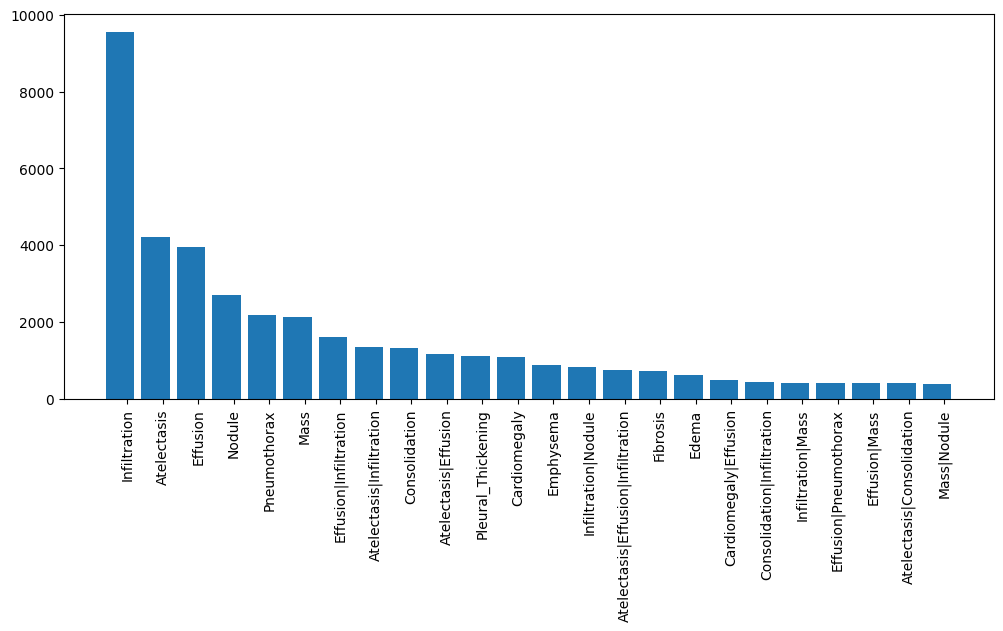

In [7]:
fig, ax = plt.subplots(1,1,figsize = (12, 5))
ax.bar(np.arange(len(df_Xray['Finding Labels'].value_counts()[1:25]))+0.5, df_Xray['Finding Labels'].value_counts()[1:25])
ax.set_xticks(np.arange(len(df_Xray['Finding Labels'].value_counts()[1:25]))+0.7)
_ = ax.set_xticklabels(df_Xray['Finding Labels'].value_counts()[1:25].index, rotation = 90)


In [8]:
# AS mentioned 
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

In [9]:
for label in labels:
    if len(label)>1:
        df_Xray[label] = df_Xray['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
df_Xray

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x  ...  Edema  Emphysema Fibrosis  \
0          2749                        0.143  ...    0.0        0.0      0.0   
1          2729                        0.143  ...    0.0        1.0      0.0   
2          2048                        0.168  ...    0.0        0.0      0.0   
3          2048                        0.171  ...    0.0        0.0      0.0   
4          2991                        0.143  ...    0.0        0.0      0.0   
...         ...                          ...  ...    ...        ...      ...   
112115     2500                        0.168  ...    0.0        0.0      0.0   
112116     2500                        0.168  ...    0.0        0.0      0.0   
112117     2500                        0.168  ...    0.0        0.0      0.0   
112118     2500                        0.168  ...    0.0        0.0      0.0   
112119     2500                        0.171  ...    0.0        0.0      0.0   

        Effusion  Pneumonia  Pleural_Thickening  Cardiomegaly  Nodule  Mass  \
0            0.0        0.0                 0.0           1.0     0.0   0.0   
1            0.0        0.0                 0.0           1.0     0.0   0.0   
2            1.0        0.0                 0.0           1.0     0.0   0.0   
3            0.0        0.0                 0.0           0.0     0.0   0.0   
4            0.0        0.0                 0.0           0.0     0.0   0.0   
...          ...        ...                 ...           ...     ...   ...   
112115       0.0        1.0                 0.0           0.0     0.0   1.0   
112116       0.0        0.0                 0.0           0.0     0.0   0.0   
112117       0.0        0.0                 0.0           0.0     0.0   0.0   
112118       0.0        0.0                 0.0           0.0     0.0   0.0   
112119       0.0        0.0                 0.0           0.0     0.0   0.0   

        Hernia  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          1.0  
...        ...  
112115     0.0  
112116     0.0  
112117     0.0  
112118     0.0  
112119     0.0  

[112120 rows x 27 columns]

In [10]:
# keep at least 1000 cases
MIN_CASES = 1000
labels = [c_label for c_label in labels if df_Xray[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(labels)), 
      [(c_label,int(df_Xray[c_label].sum())) for c_label in labels])
sample_weights = df_Xray['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
df_Xray = df_Xray.sample(40000, weights=sample_weights)

Clean Labels (13) [('Atelectasis', 11559), ('Consolidation', 4667), ('Infiltration', 19894), ('Pneumothorax', 5302), ('Edema', 2303), ('Emphysema', 2516), ('Fibrosis', 1686), ('Effusion', 13317), ('Pneumonia', 1431), ('Pleural_Thickening', 3385), ('Cardiomegaly', 2776), ('Nodule', 6331), ('Mass', 5782)]


In [11]:
df_Xray['Finding Labels'].map(lambda x: x[:2])

12791    No
72146    At
70970    Co
32586    At
38294    Ed
         ..
31506    Pn
74817    Ef
81455    No
77419    No
98657    No
Name: Finding Labels, Length: 40000, dtype: object

In [12]:
train,test = train_test_split(df_Xray,test_size=0.15,stratify = df_Xray['Finding Labels'].map(lambda x: x[:2]))

In [13]:
train.shape,test.shape

((34000, 27), (6000, 27))

In [14]:
test.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
       'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'],
      dtype='object')

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
BATCH_SIZE=32
IMAGE_SIZE=224
image_gen = ImageDataGenerator(horizontal_flip=True
                             
                             )


In [16]:
train_generator = image_gen.flow_from_dataframe(dataframe=train,
                                        x_col = 'path',
                                        y_col = labels,
                                        class_mode = 'raw',
                                        target_size =(224, 224),
                                        color_mode = 'grayscale',
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)
valid_generator = image_gen.flow_from_dataframe(dataframe=test,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = labels,
                                        class_mode = 'raw',
                                        target_size = (224, 224),
                                        color_mode = 'grayscale',
                                        batch_size = 32)

Found 34000 validated image filenames.
Found 6000 validated image filenames.


In [17]:

train_data_tf = tf.data.Dataset.from_generator(
                lambda: train_generator,
                output_types = (tf.float32, tf.float32), 
                output_shapes = ([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(labels)]))


valid_data_tf = tf.data.Dataset.from_generator(
                lambda: valid_generator,
                output_types=(tf.float32, tf.float32), 
                output_shapes=([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(labels)]))

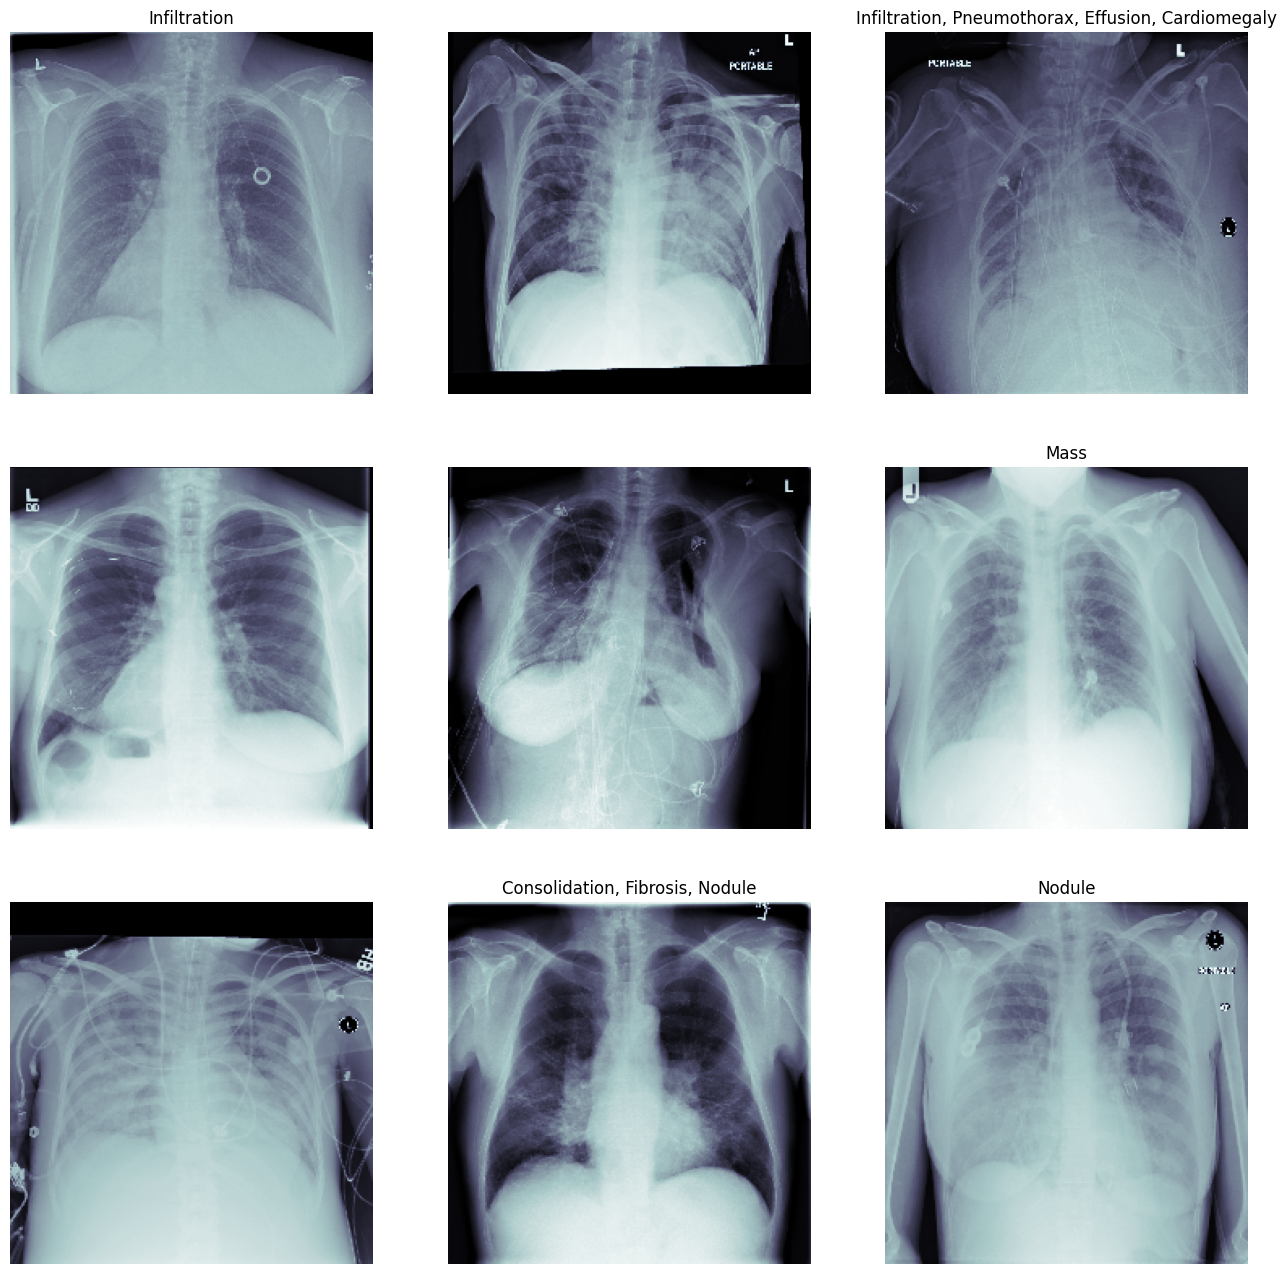

In [18]:
batch_sample = next(iter(train_data_tf))
image_sample, label_sample = batch_sample
fig, axes = plt.subplots(3, 3, figsize = (16, 16))
for (img, lb, ax) in zip(image_sample, label_sample, axes.flatten()):
    ax.imshow(img, cmap = 'bone')
    img_lab_name = np.array(labels)[lb.numpy() == 1.0]
    
    ax.set_title(', '.join(img_lab_name))
    ax.axis('off')

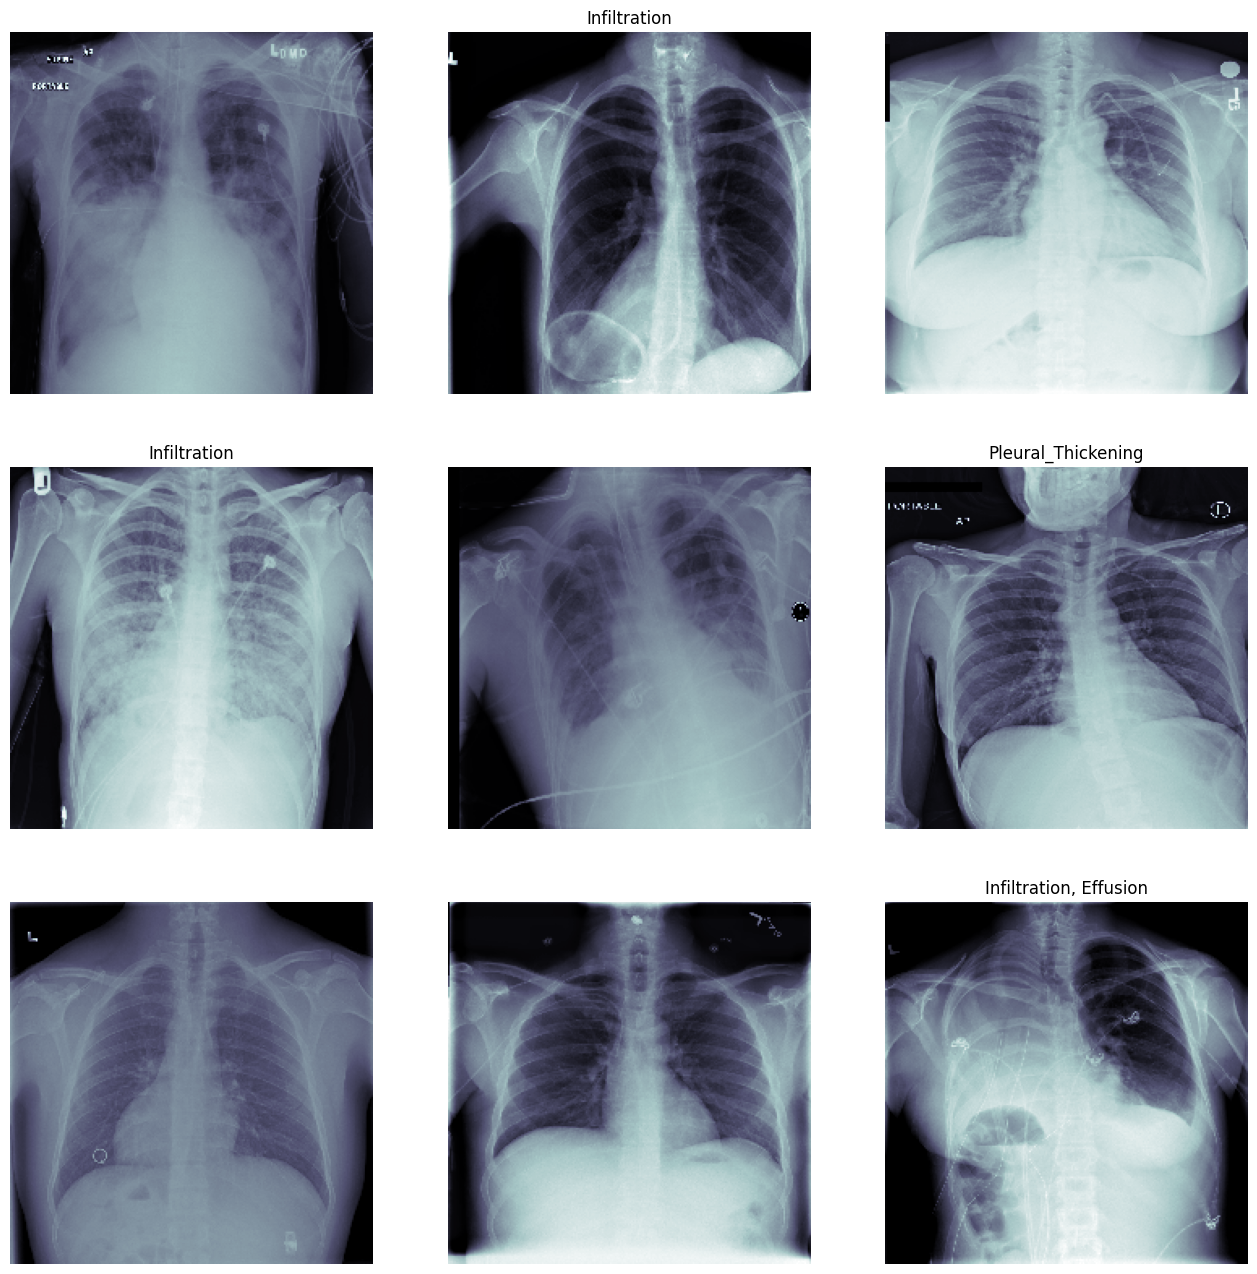

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
batch_sample = next(iter(train_data_tf))
image_sample, label_sample = batch_sample
fig, axes = plt.subplots(3, 3, figsize = (16, 16))
for (img, lb, ax) in zip(image_sample, label_sample, axes.flatten()):
#     print(img)
    
    ax.imshow(img, cmap = 'bone')
    img_lab_name = np.array(labels)[lb.numpy() == 1.0]
    
    ax.set_title(', '.join(img_lab_name))
    ax.axis('off')

Normalizing and changing color to RGB

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = tf.keras.layers.Rescaling(1./255)
sc_train_data = train_data_tf.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)
sc_valid_data = valid_data_tf.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)
valid_data = sc_valid_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)
train_data = sc_train_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)

# Background Noise Removal and Enhancing the image contrast

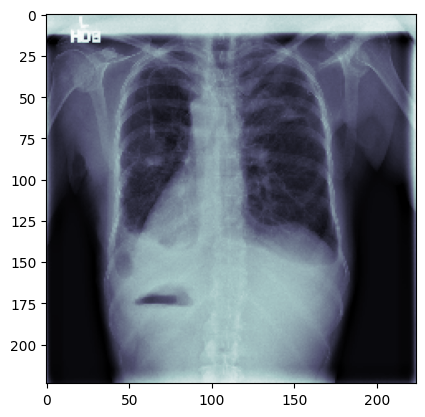

In [21]:

def background_noise_removal(image, denoise_weight=0.01, ball_radius=50, denoise=False):
   
    img_list = []
    for i in range(image.shape[0]):
        try:
            img = image[i]

            # Rolling Ball Background Subtraction
            background = black_tophat(img, ball_radius)
            roi = img - background
            roi = tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(roi)

            # Denoise
            roi = denoise_tv_chambolle(img_as_float(roi), weight=denoise_weight)

            img_list.append(roi)
        except:
            img_list.append(img)

    return tf.convert_to_tensor(tf.stack(img_list))

def image_processing_pipeline(image, label, clip_limit=2.0, denoise_weight=0.01):
    im_shape = image.shape
    [image,] = tf.py_function(background_noise_removal, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

enhanced_contrast_train_data = sc_train_data.map(
    lambda image, label: image_processing_pipeline(image, label, clip_limit=2.0, denoise_weight=0.01),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
enhanced_contrast_valid_data = sc_valid_data.map(
    lambda image, label: image_processing_pipeline(image, label, clip_limit=2.0, denoise_weight=0.01),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

for image, label in enhanced_contrast_train_data.take(1):
    plt.imshow(image[1], cmap='bone')


In [22]:
valid_data_enhanced = enhanced_contrast_valid_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)
train_data_enhanced = enhanced_contrast_train_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)

In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,BatchNormalization,Input,Conv2D,MaxPooling2D,concatenate,Conv2DTranspose
from keras.models import Sequential

In [24]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from keras import optimizers
from keras import layers
# Define the number of classes

input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)

eff = tf.keras.applications.VGG16(include_top = False,weights = 'imagenet') 
eff = eff(input)
normal = BatchNormalization() (eff)
flatten = GlobalAveragePooling2D() (normal)
dense1 = Dense(256,activation = 'relu') (flatten)
output = Dense(len(labels), activation = 'sigmoid') (dense1)
model = tf.keras.Model(inputs=[input], outputs=[output])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 13)                1677  

In [25]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])

In [26]:
steps_per_epoch = train.shape[0]  // 32
steps_per_epoch
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=2)
callbacks_list = [checkpoint, early]

In [34]:
model.fit(train_data, 
                  steps_per_epoch = 150,
#                 validation_data =valid_data,
                  epochs = 5,
                verbose = 1,
          callbacks = callbacks_list
                  )

Epoch 1/5
150/150 [==============================] - 117s 776ms/step - loss: 0.2436 - binary_accuracy: 0.9231 - auc: 0.7391
Epoch 2/5
150/150 [==============================] - 117s 780ms/step - loss: 0.2348 - binary_accuracy: 0.9259 - auc: 0.7504
Epoch 3/5
150/150 [==============================] - 116s 771ms/step - loss: 0.2341 - binary_accuracy: 0.9260 - auc: 0.7464
Epoch 4/5
150/150 [==============================] - 118s 787ms/step - loss: 0.2398 - binary_accuracy: 0.9232 - auc: 0.7504
Epoch 5/5
150/150 [==============================] - 120s 798ms/step - loss: 0.2350 - binary_accuracy: 0.9250 - auc: 0.7536


In [29]:
tf.saved_model.save(model, "model_vgg16.h5")


In [ ]:
from keras.models import load_model
model = load_model("/kaggle/input/vgg-16-model/xray_vgg16_.h5")



In [37]:
test_X, test_Y = next(image_gen.flow_from_dataframe(dataframe=test,
                                        x_col = 'path',
                                        y_col = labels,
                                        class_mode = 'raw',
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = 16))
test_X_normalz = tf.keras.layers.Rescaling(1./255) (test_X)
test_X_normalz = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_normalz))

Found 6000 validated image filenames.


In [38]:
y_pred_vgg16 = model.predict(test_X_normalz)
y_pred_vgg16[:5]

32/32 [==============================] - 4s 123ms/step


array([[0.01516235, 0.01382378, 0.16194396, 0.02620204, 0.00262346,
        0.01061746, 0.00414982, 0.02656871, 0.00970781, 0.00991926,
        0.00425082, 0.00811713, 0.01079071],
       [0.00759567, 0.0060029 , 0.12917967, 0.01330673, 0.00049876,
        0.00627214, 0.00386431, 0.01794803, 0.00636888, 0.00633916,
        0.00209455, 0.00604972, 0.00629818],
       [0.01556038, 0.01660734, 0.18036659, 0.02754787, 0.00308593,
        0.01238549, 0.00430126, 0.02935836, 0.01154804, 0.01031472,
        0.00487209, 0.00770925, 0.01040424],
       [0.01918976, 0.01409987, 0.16341308, 0.02921687, 0.00237121,
        0.01326813, 0.0056723 , 0.0375318 , 0.01271519, 0.0121287 ,
        0.0048935 , 0.00995619, 0.01115543],
       [0.12102614, 0.07348363, 0.35766432, 0.07864317, 0.07403302,
        0.01851907, 0.00511928, 0.13970645, 0.03096608, 0.03168843,
        0.02602635, 0.02589585, 0.04073873]], dtype=float32)

In [39]:
test_X_normalz = tf.keras.layers.Rescaling(1./255) (test_X)
test_X_normalz = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_normalz))

0.5876165622340938


Text(0, 0.5, 'True Positive Rate')

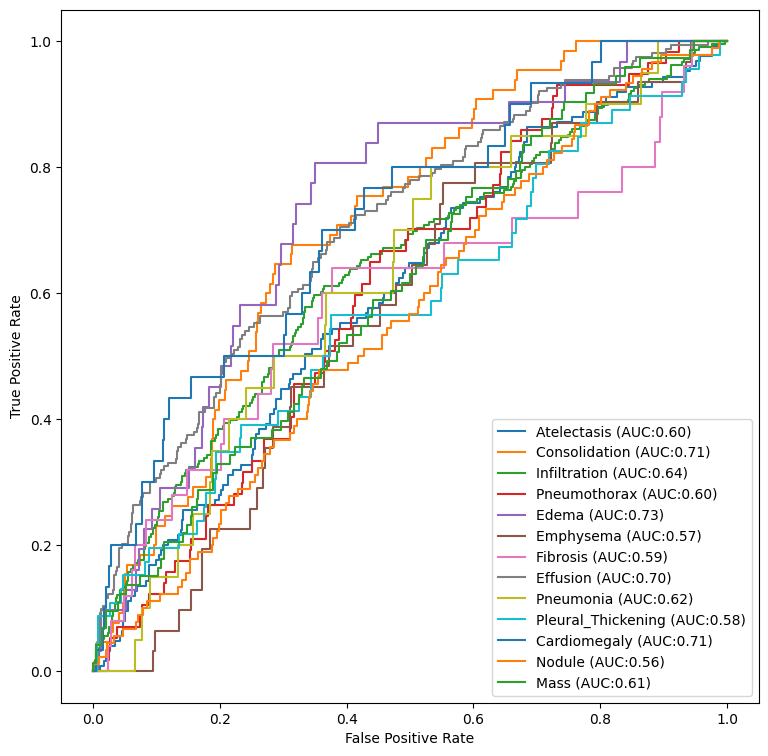

In [40]:

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_vgg16 = 0
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_vgg16[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_vgg16 += auc(fpr, tpr)
mean_auc_vgg16 /= 14
print(mean_auc_vgg16)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

In [41]:
for c_label, s_count in zip(labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 12.21%
Consolidation: 6.35%
Infiltration: 21.09%
Pneumothorax: 5.57%
Edema: 3.03%
Emphysema: 3.03%
Fibrosis: 2.44%
Effusion: 15.92%
Pneumonia: 1.95%
Pleural_Thickening: 4.49%
Cardiomegaly: 2.93%
Nodule: 8.79%
Mass: 7.13%


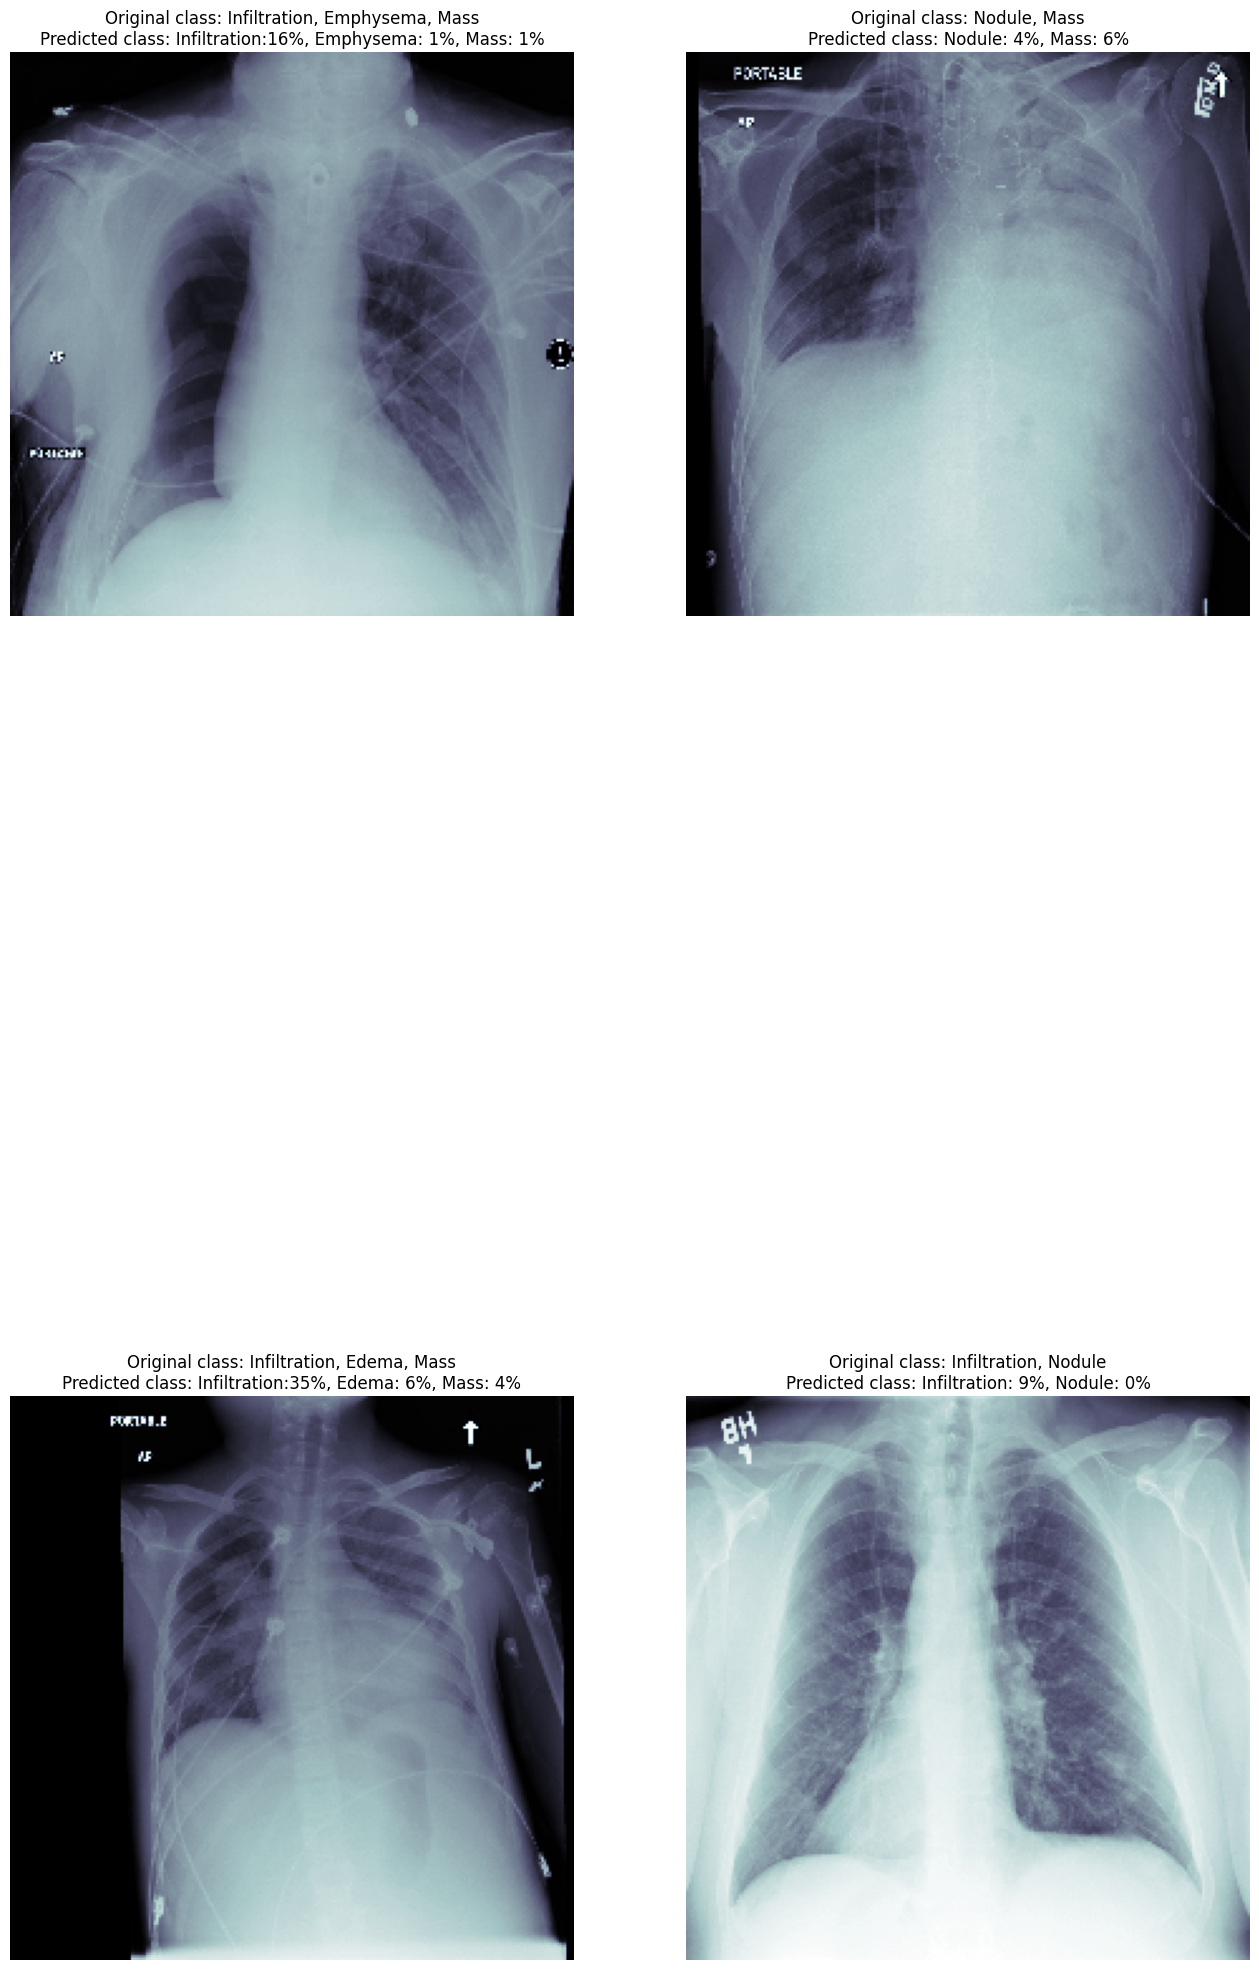

In [47]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(2, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:14] for n_class, n_score in zip(labels,test_Y[idx]) if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:14], p_score*100)  for n_class, n_score, p_score in zip(labels, test_Y[idx], y_pred_vgg16[idx]) if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Original class: '+', '.join(stat_str)+'\nPredicted class: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('prediction.png')

#  **Future Work **

* Model Accuracy can be increased with increasing number of  layers,step and epochs
* Labelling of images while hot encoding.
* Cutom model can be using on top of the pretrained model.
* Noise, contrast and saturation can be improved on fine tunning which proper ranges
